<a href="https://colab.research.google.com/github/zmohaveri/IVT-ActiveLearning/blob/main/IVT_iter1_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#imports

In [1]:
import numpy as np
import pandas as pd
%matplotlib notebook
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from math import sqrt
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from collections import OrderedDict 
import tensorflow as tf
from sklearn.model_selection import train_test_split
import time as tm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations 

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
plt.clf()

<Figure size 432x288 with 0 Axes>

#Import and clean the data

In [3]:
path='/content/drive/My Drive/Thesis/201008-ZM-IVT-iter1/201008-ZM-IVT-iter1.xlsx'
df=pd.read_excel(path,header=11)#,usecols=(lambda x: type(x) is not str))
df.drop(labels='Time [s]',axis=1,inplace=True)
df.head(3)

,Unnamed: 0,Unnamed: 1,0,240,480,720,960,1200,1440,1680,1920,2160,2400,2640,2880,3120,3360,3600,3840,4080,4320,4560,4800,5040,5280,5520,5760,6000,6240,6480,6720,6960,7200,7440,7680,7920,8160,8400,8640,8880,...,50400,50640,50880,51120,51360,51600,51840,52080,52320,52560,52800,53040,53280,53520,53760,54000,54240,54480,54720,54960,55200,55440,55680,55920,56160,56400,56640,56880,57120,57360,57600,57840,58080,58320,58560,58800,59040,59280,59520,59760
0,A,10,1008,1566,2465,3560,4691,5752,6647,7518,8134,8924,9527,10182,10674,11155,11528,11847,12154,12437,12621,12838,12968,13116,13178,13286,13395,13382,13471,13479,13508,13592,13581,13583,13543,13562,13581,13545,13546,13532,...,14098,14060,14099,14077,14065,14049,14056,14052,14087,14070,14084,14084,14120,14115,14077,14104,14102,14094,14119,14164,14157,14156,14138,14138,14096,14161,14160,14201,14166,14170,14194,14137,14197,14202,14189,14162,14200,14214,14257,14218
1,A,11,1165,1161,1137,1101,1094,1102,1113,1128,1031,1129,1099,1084,1053,1023,987,925,883,883,877,874,881,867,861,859,866,857,871,875,873,884,886,894,891,894,885,890,886,890,...,843,833,835,835,835,838,836,838,838,837,837,839,841,833,831,836,833,835,834,839,837,832,833,836,840,839,836,835,837,836,834,832,835,834,826,839,837,845,838,834
2,A,12,756,819,896,970,1027,1064,1047,1103,1133,1153,1160,1173,1181,1174,1152,1134,1135,1130,1127,1132,1139,1128,1122,1123,1124,1118,1128,1124,1116,1126,1123,1120,1131,1122,1127,1117,1120,1117,...,1041,1039,1039,1034,1041,1037,1044,1039,1043,1040,1034,1042,1042,1034,1033,1032,1031,1036,1033,1039,1038,1042,1041,1029,1047,1036,1035,1038,1036,1027,1029,1031,1034,1035,1030,1034,1029,1030,1031,1028


In [4]:
dimensions=(8,8)
time=[t for t in df][2:]
arr=df.to_numpy()
arr=arr.reshape(15,15,252)
filled=np.ones((8,8,250),dtype=object)
well_names=np.empty((8,8,2),dtype=object)
for i in range(8): 
  for j in range(8):
    for k in range (250): 
      filled[i,j,k]=arr[i*2,j*2,k+2]
    well_names[i,j]=arr[i*2,j*2,:2]

#Functions for processing data (plot, slopes etc.)

In [32]:

def plot_all_wells(data:list,names,title:str,size=(30,20),hspace=.3):
  fig, ax = plt.subplots(dimensions[0],dimensions[1],figsize=size)
  fig.suptitle(title,fontsize=35)

  for tup in data:
    time,array=tup
    array=np.array(array)
    for i in range(dimensions[0]):
      for j in range (dimensions[1]):
        ax[i,j].plot(time,array[i,j,:])
        ax[i,j].set_title(f'{names[i,j,0]}{names[i,j,1]}')
  plt.subplots_adjust(hspace=hspace)
  plt.show()
  save_plot_to_file(title)

def plot_one_well():
  i=1
#first derivative
#slope fitting function

def fit_line_to_range(array,fitting_range):
  slopes=np.ones(dimensions)
  intercepts=np.ones(dimensions)
  for i in range(dimensions[0]):
    for j in range(dimensions[1]):
      slopes[i,j]=linregress(time[:fitting_range],array[i,j,:fitting_range])[0]#slope
      intercepts[i,j]=linregress(time[:fitting_range],array[i,j,:fitting_range])[1]
  return np.array(slopes),np.array(intercepts)

def save_plot_to_file(title):
  plt.savefig(f'/content/drive/My Drive/Thesis/201008-ZM-IVT-iter1/201008-ZM-IVT-iter1-{title}.png')
  plt.clf()

def save_model_to_file(model,title):
  def myprint(s):
    with open(f'/content/drive/My Drive/Thesis/201008-ZM-IVT-iter1/201008-ZM-IVT-iter1-{title}.txt','w+') as f:
        print(s, file=f)
  model.summary(print_fn=myprint)

def saving_path(title,extension):
  string=f'/content/drive/My Drive/Thesis/201008-ZM-IVT-iter1/201008-ZM-IVT-iter1-{title}.{extension}'
  return string

###smoothed data

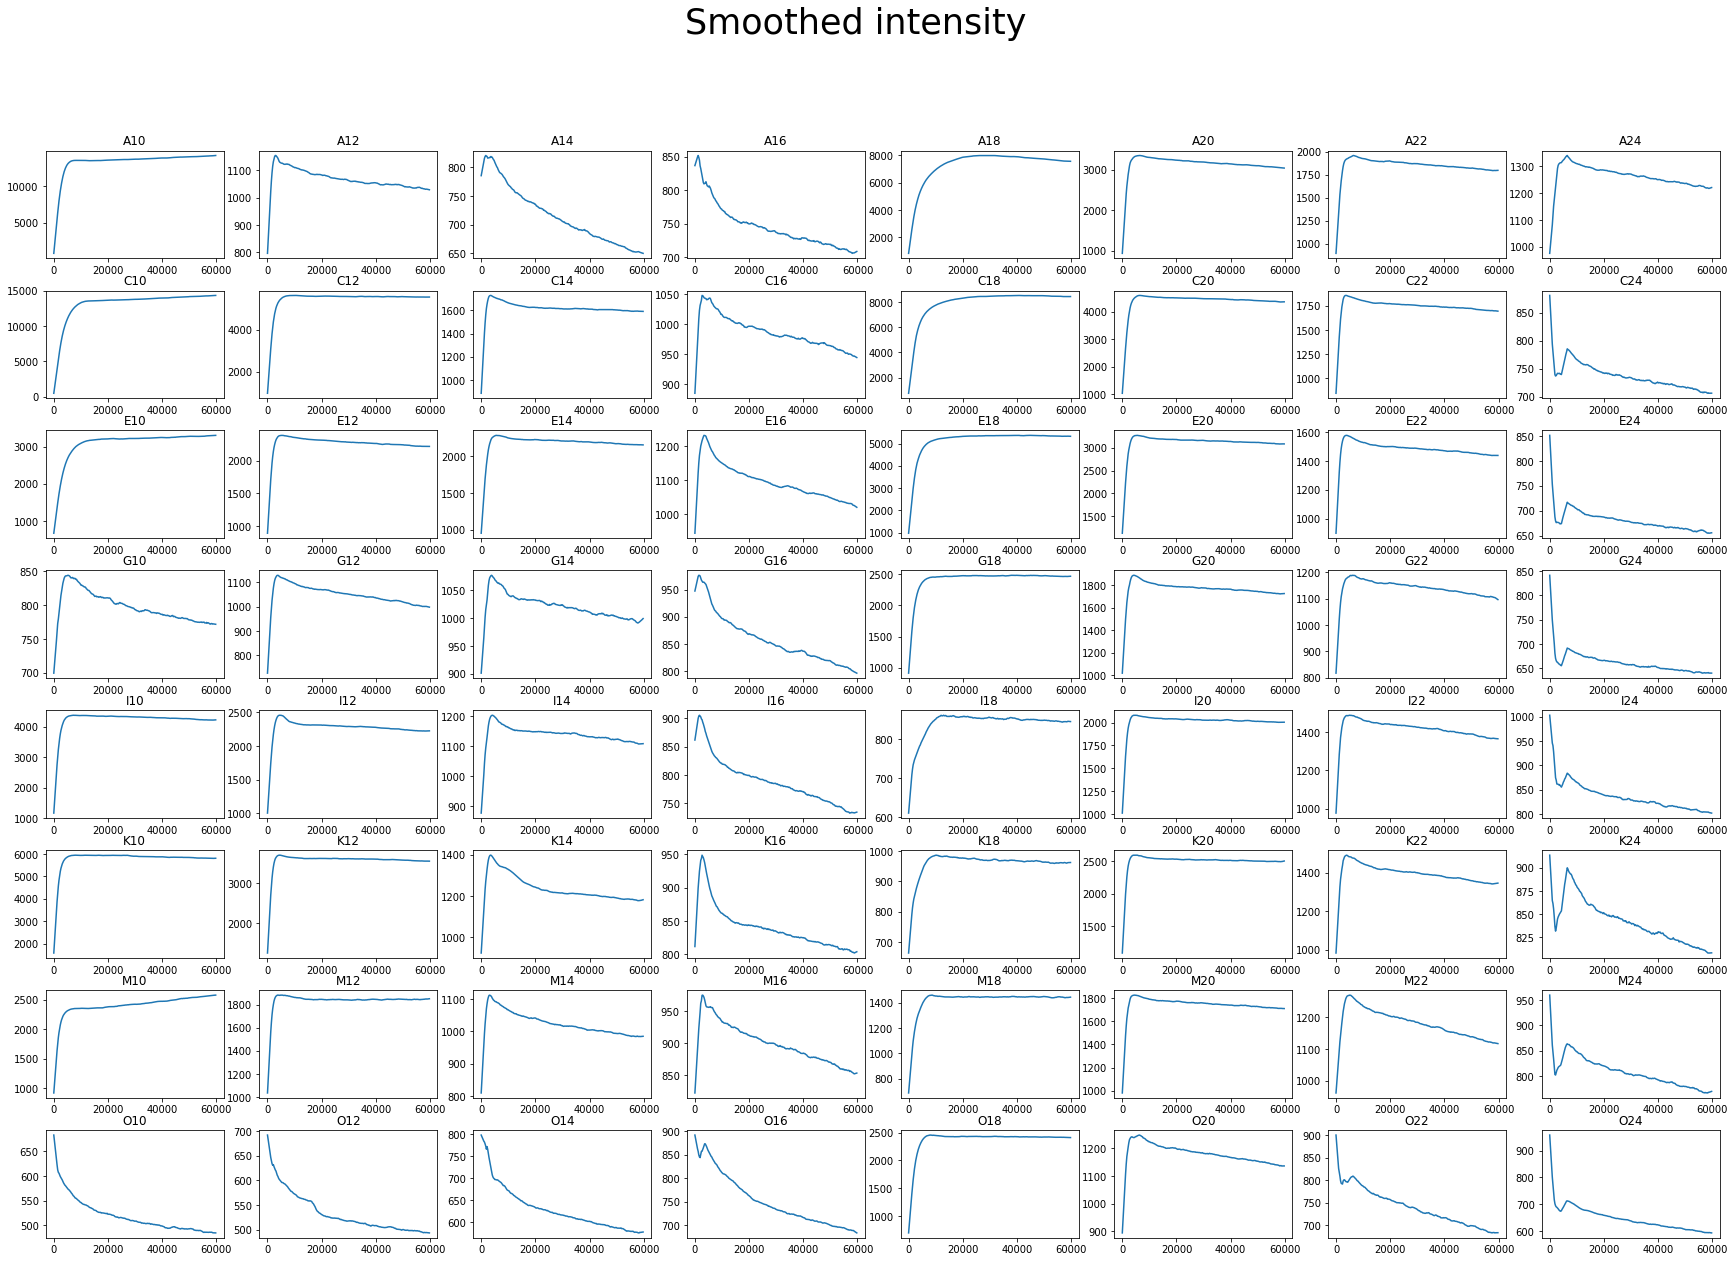

<Figure size 432x288 with 0 Axes>

In [33]:
smoothed=savgol_filter(filled,9,1)
plot_all_wells([(time,smoothed)],well_names,'Smoothed intensity')

#Plot well plate

In [7]:
plot_all_wells([(time,filled)],well_names,'Plate View')

<Figure size 2160x1440 with 0 Axes>

#Labeling (fit)

###trying gradient method

In [8]:
gradients=np.gradient(smoothed,axis=-1,edge_order=2)
plot_all_wells([(time,gradients)],well_names,'gradients')
max_rates_indices=np.argmax(gradients,axis=-1)
max_rates=np.ones((8,8))
for i in range(dimensions[0]):
  for j in range(dimensions[1]):
    max_rates[i,j]=gradients[i,j,max_rates_indices[i,j]]

<Figure size 2160x1440 with 0 Axes>

In [9]:
print(max_rates)
print(max_rates_indices)

[[9.48600000e+02 4.59333333e+01 6.13333333e+00 3.18333333e+00
  3.53633333e+02 2.51133333e+02 1.08716667e+02 3.48333333e+01]
 [6.82888889e+02 4.33050000e+02 1.05666667e+02 2.14083333e+01
  4.14586111e+02 3.30666667e+02 1.18400000e+02 5.38888889e+00]
 [1.37900000e+02 1.67100000e+02 1.27033333e+02 3.61333333e+01
  2.93250000e+02 2.25883333e+02 8.62666667e+01 5.44444444e+00]
 [1.29444444e+01 4.67500000e+01 1.86111111e+01 5.46666667e+00
  1.35600000e+02 9.76333333e+01 4.16166667e+01 4.44444444e+00]
 [3.22716667e+02 1.50283333e+02 3.44777778e+01 7.92222222e+00
  1.98666667e+01 1.26733333e+02 6.19000000e+01 3.66666667e+00]
 [4.66350000e+02 2.97266667e+02 5.27611111e+01 1.76305556e+01
  2.59166667e+01 1.85050000e+02 5.87694444e+01 6.00000000e+00]
 [1.45916667e+02 1.07016667e+02 3.69500000e+01 1.71305556e+01
  6.14833333e+01 9.95333333e+01 2.83083333e+01 5.33333333e+00]
 [8.33333333e-01 8.33333333e-01 6.66666667e-01 6.61111111e+00
  1.43616667e+02 4.32000000e+01 4.55555556e+00 4.88888889e+00]]

In [10]:
initial_rate=np.mean(gradients[:,:,:5],axis=2)
initial_rate

array([[941.69555556,  45.75111111,   6.08666667,   3.09833333,
        350.78111111, 250.24222222, 108.57833333,  27.62833333],
       [678.03166667, 429.08944444, 104.63333333,  21.20166667,
        414.34388889, 328.38888889, 117.52666667, -20.90166667],
       [137.19888889, 165.35666667, 126.50777778,  35.83111111,
        293.05833333, 223.895     ,  85.41777778, -23.71388889],
       [ 12.065     ,  46.30833333,  16.23222222,   5.43111111,
        134.70666667,  96.80333333,  41.29944444, -22.27833333],
       [319.87833333, 149.255     ,  32.28222222,   7.50444444,
         19.71333333, 125.44888889,  61.62111111, -13.37333333],
       [462.23722222, 294.28444444,  52.39222222,  17.51277778,
         25.74722222, 182.81166667,  58.67388889, -11.30222222],
       [144.50277778, 106.25944444,  36.77722222,  16.87944444,
         61.04611111,  99.33555556,  26.955     , -23.41388889],
       [-12.13555556,  -9.22222222,  -3.34222222,  -7.09555556,
        142.11055556,  42.8688888

###Going back to initial rates

I decided to go beck to just fitting a line to the very beginning.

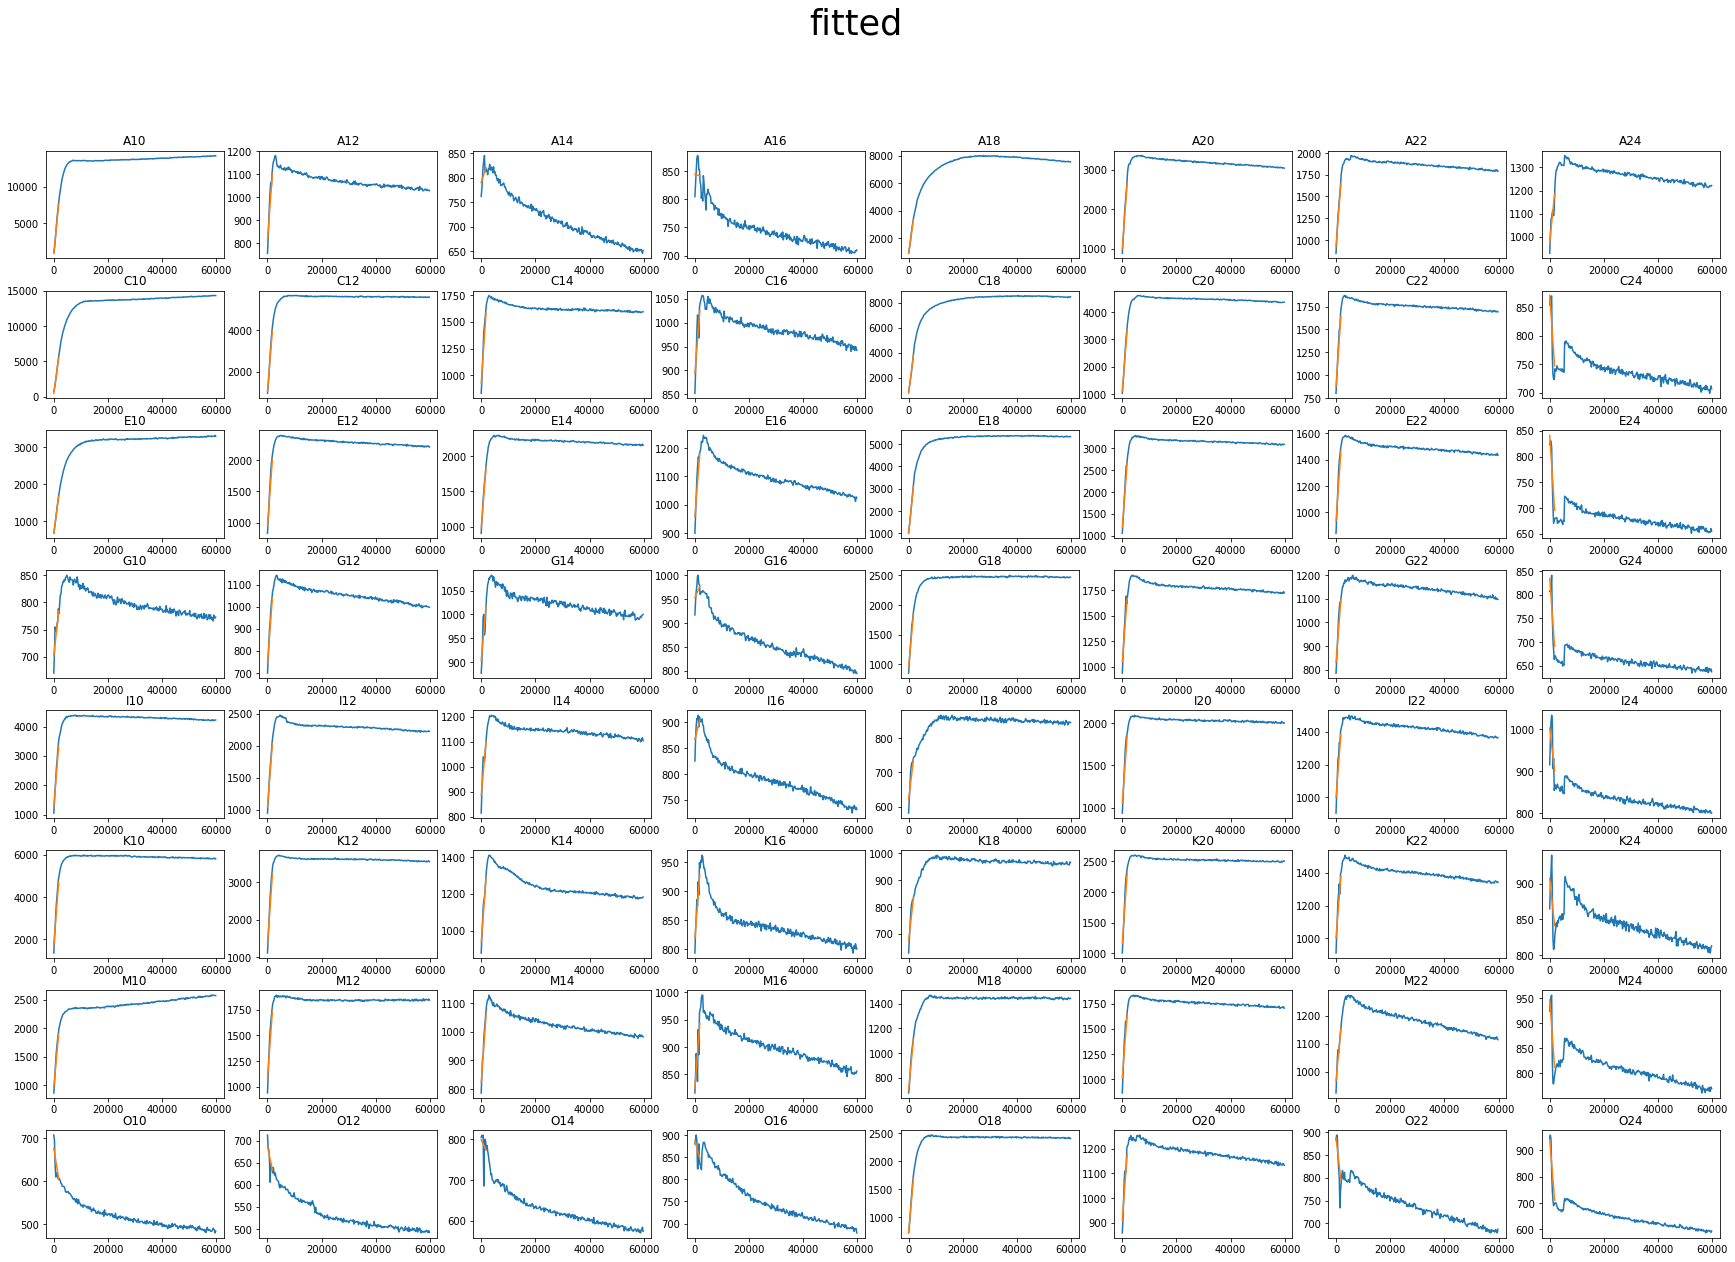

<Figure size 432x288 with 0 Axes>

In [34]:
slopes,intercepts=fit_line_to_range(smoothed,10)
fits=[[[intercepts[i,j],(slopes[i,j]*10*180 + intercepts[i,j])]for j in range(8)]for i in range(8)]
plot_all_wells([(time,filled),([0,10*180],fits)],well_names,'fitted')

In [12]:
slopes.shape

(8, 8)

In [13]:

normalized_slopes=( slopes-slopes.min() )/(slopes.max()-slopes.min())
print(normalized_slopes)
print(normalized_slopes.mean(),normalized_slopes.max(),normalized_slopes.min())

def back_normalization_slopes(label):
  return (label *  (slopes.max()-slopes.min()) )+slopes.min()

[[1.         0.07521701 0.03742913 0.03277291 0.38965506 0.27443096
  0.13809371 0.06380728]
 [0.76388006 0.45175713 0.12880727 0.05222659 0.47669548 0.35832709
  0.14395947 0.01514891]
 [0.17568502 0.1873133  0.15734642 0.0651607  0.33632729 0.24753882
  0.11010918 0.01197789]
 [0.04513189 0.07620141 0.04977713 0.03640995 0.16272565 0.1237436
  0.0712051  0.01230371]
 [0.33584625 0.17729688 0.06454934 0.03850541 0.05011539 0.14842569
  0.08887194 0.01826538]
 [0.46371122 0.30135495 0.08371821 0.04915515 0.05649    0.19887971
  0.08762249 0.02344327]
 [0.16854016 0.12851111 0.06722504 0.05012601 0.0929761  0.12457534
  0.06012375 0.01356889]
 [0.02278724 0.02529492 0.02935771 0.02726152 0.1738923  0.0719369
  0.01969054 0.        ]]
0.1489575618882742 1.0 0.0


#building data set

##Protocol to Inputs

In [14]:

scanning_profile=OrderedDict({'t3r5':(100,0.5),'template':(50,0.5),'mgcl2':(20,0.5),'rntp':(5,0.5)})
grid_profile_keys=[[1,2,1,2],[1,2,2,-1],[1,2,-1,-2],[1,2,-2,1]]

##function to turn profile keys to concentrations in 8*8

def fill_a_block(direction,initial_concentration,dilution_coefficient,n_wells_in_block=4,real_concentrations=False):
  if real_concentrations:
    diluted_concentraitions=dilution_concentraitions(initial_concentration,dilution_coefficient,n_wells_in_block)
  else:
    diluted_concentraitions=dilution_concentraitions(1,dilution_coefficient,n_wells_in_block) #fix for next iteration

  if direction<0:
    diluted_concentraitions.reverse()
  direction=abs(direction)
  block=np.stack([diluted_concentraitions]*n_wells_in_block,axis=direction-1)
  return block


def dilution_concentraitions(initial_concentration,dilution_coefficient,number_of_wells=4):
  concentrations=[]
  c=initial_concentration
  for i in range(number_of_wells):
    concentrations.append(c)
    c=c*dilution_coefficient
  return concentrations

def build_grid_out_of_blocks(block1,block2,block3,block4):
  l1=np.concatenate((block1,block2),axis=1)
  l2=np.concatenate((block3,block4),axis=1)
  return np.concatenate((l1,l2),axis=0)
  #this only works with 4 blocks. I don't know how we want to represent more number of blocks. Update in future cases.

def grid_profile_to_concentration(scanning_profile,grid_profile_keys,real_concentrations=False):
  number_of_elements=len(scanning_profile)
  number_of_blocks=len(grid_profile_keys)
  concentrations=OrderedDict({})
  for i,material in enumerate(scanning_profile):
    blocks=[]
    for b in range (number_of_blocks):
      direction=grid_profile_keys[b][i]
      block=fill_a_block(direction,scanning_profile[material][0],scanning_profile[material][1],real_concentrations=real_concentrations)
      blocks.append(block)
    concentrations[material]=build_grid_out_of_blocks(blocks[0],blocks[1],blocks[2],blocks[3])

  return concentrations

scanning_concentrations=grid_profile_to_concentration(scanning_profile,grid_profile_keys)
for element in scanning_concentrations:
  print(element,'\n',scanning_concentrations[element])
  print(scanning_concentrations[element].shape)
  scanning_concentrations[element]=scanning_concentrations[element].flatten()
  print(scanning_concentrations[element].shape)


t3r5 
 [[1.    0.5   0.25  0.125 1.    0.5   0.25  0.125]
 [1.    0.5   0.25  0.125 1.    0.5   0.25  0.125]
 [1.    0.5   0.25  0.125 1.    0.5   0.25  0.125]
 [1.    0.5   0.25  0.125 1.    0.5   0.25  0.125]
 [1.    0.5   0.25  0.125 1.    0.5   0.25  0.125]
 [1.    0.5   0.25  0.125 1.    0.5   0.25  0.125]
 [1.    0.5   0.25  0.125 1.    0.5   0.25  0.125]
 [1.    0.5   0.25  0.125 1.    0.5   0.25  0.125]]
(8, 8)
(64,)
template 
 [[1.    1.    1.    1.    1.    1.    1.    1.   ]
 [0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5  ]
 [0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25 ]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [1.    1.    1.    1.    1.    1.    1.    1.   ]
 [0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5  ]
 [0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25 ]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]]
(8, 8)
(64,)
mgcl2 
 [[1.    0.5   0.25  0.125 1.    1.    1.    1.   ]
 [1.    0.5   0.25  0.125 0.5   0.5   0.5   0.5  ]
 [1.    0.5   0.25  0.125 0.

##checking the distribution

In [15]:
def plot_3d_distribution (xs,ys,zs,name,xlabel='x',ylabel='y',zlabel='z'):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(xs, ys, zs, zdir='z')
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_zlabel(zlabel)
  plt.show()
  plt.savefig(saving_path(f'distribution-{name}','jpg'))
  plt.clf()

def plot_2d_distribution (x,y,name,xlabel='x',ylabel='y'):
  #fig, ax = plt.subplots(dimensions[0],dimensions[1],figsize=100)
  fig, ax = plt.subplots()
  plt.scatter(x,y,alpha=0.2)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  plt.show()
  plt.savefig(saving_path(f'distribution-{name}','jpg'))
  plt.clf()

('t3r5', 'template', 'mgcl2')
(64,) (64,) (64,)


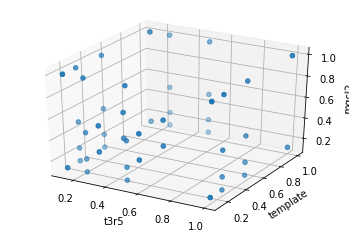

('t3r5', 'template', 'rntp')
(64,) (64,) (64,)


<Figure size 432x288 with 0 Axes>

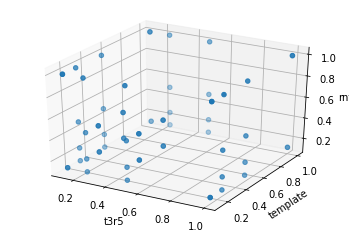

('t3r5', 'mgcl2', 'rntp')
(64,) (64,) (64,)


<Figure size 432x288 with 0 Axes>

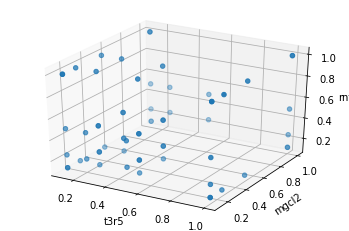

('template', 'mgcl2', 'rntp')
(64,) (64,) (64,)


<Figure size 432x288 with 0 Axes>

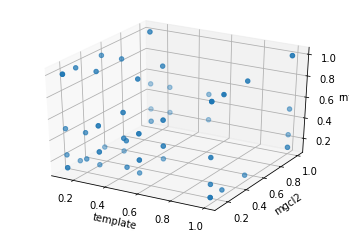

<Figure size 432x288 with 0 Axes>

In [16]:

comb=combinations(scanning_profile,3)
for names in comb:
  print(names)
  xlabel,ylabel,zlabel=names
  xs=scanning_concentrations[xlabel]
  ys=scanning_concentrations[ylabel]
  zs=scanning_concentrations[zlabel]
  print(xs.shape,ys.shape,zs.shape)
  plot_3d_distribution(xs,ys,zs,str(names),xlabel,ylabel,zlabel)

('t3r5', 'template')


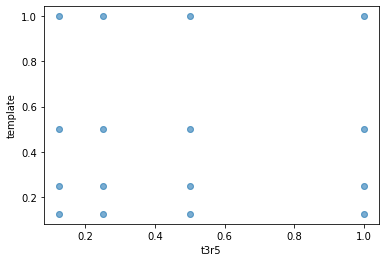

('t3r5', 'mgcl2')


<Figure size 432x288 with 0 Axes>

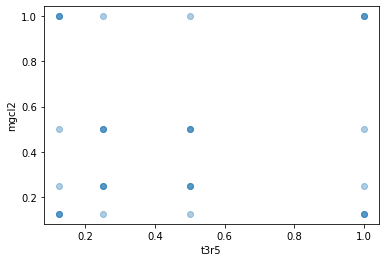

('t3r5', 'rntp')


<Figure size 432x288 with 0 Axes>

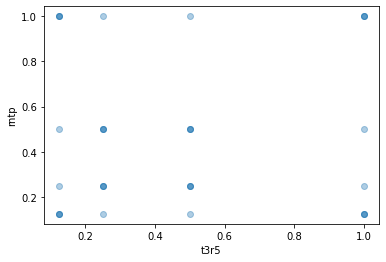

('template', 'mgcl2')


<Figure size 432x288 with 0 Axes>

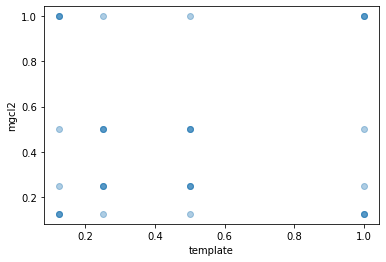

('template', 'rntp')


<Figure size 432x288 with 0 Axes>

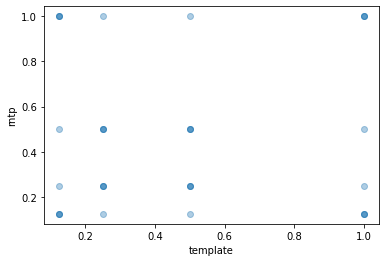

('mgcl2', 'rntp')


<Figure size 432x288 with 0 Axes>

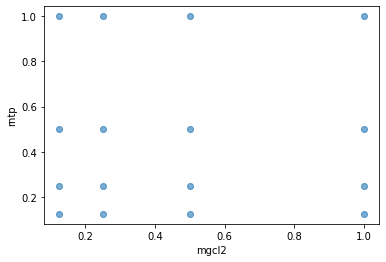

<Figure size 432x288 with 0 Axes>

In [17]:
comb=combinations(scanning_profile,2)
for names in comb:
  print(names)
  xlabel,ylabel=names
  xs=scanning_concentrations[xlabel]
  ys=scanning_concentrations[ylabel]
  plot_2d_distribution(xs,ys,str(names),xlabel,ylabel)

##building dataset (connecting inputs and output)

In [18]:
#How do I want my dataset to look like? 64 flattened wells, containing 4 infos each
dataset_size=dimensions[0]*dimensions[1]
dataset_x=np.array([[scanning_concentrations[element][i] for element in scanning_concentrations] for i in range(dataset_size)])
dataset_y=normalized_slopes.flatten()

In [19]:
print(dataset_x.shape)
print(dataset_x[0],dataset_x[63])
print(dataset_y.shape)

(64, 4)
[1. 1. 1. 1.] [0.125 0.125 1.    0.125]
(64,)


#Training a NN model

In [45]:
x_train,x_test,y_train,y_test = train_test_split(dataset_x,dataset_y,test_size=0.1,random_state=100)

In [46]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(57, 4) (7, 4) (57,) (7,)


In [47]:
print(x_train[0])

[0.5  1.   1.   0.25]


model description

In [55]:
iter1_model = Sequential([
                    Dense(10,activation='relu', input_shape=(4,),name='layer1')])
#iter1_model.add(LeakyReLU(alpha=0.01))
iter1_model.add(Dense(4,activation='relu',name='layer2'))
#iter1_model.add(Dense(4,activation='relu',name='layer3'))
iter1_model.add(Dense(1,activation='relu',name='output'))

compilation

In [56]:
iter1_model.compile(
    optimizer='adam',
    loss='MeanSquaredError', #MeanSquaredLogarithmicError
)

iter1_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 10)                50        
_________________________________________________________________
layer2 (Dense)               (None, 4)                 44        
_________________________________________________________________
output (Dense)               (None, 1)                 5         
Total params: 99
Trainable params: 99
Non-trainable params: 0
_________________________________________________________________


training

In [57]:
iter1_history=iter1_model.fit(x_train,y_train,batch_size=5,epochs=300)
loss_history=iter1_history.history['loss']

Epoch 1/300
12/12 [==============================] - 0s 1ms/step - loss: 0.0538
Epoch 2/300
12/12 [==============================] - 0s 1ms/step - loss: 0.0448
Epoch 3/300
12/12 [==============================] - 0s 1ms/step - loss: 0.0359
Epoch 4/300
12/12 [==============================] - 0s 1ms/step - loss: 0.0323
Epoch 5/300
12/12 [==============================] - 0s 1ms/step - loss: 0.0290
Epoch 6/300
12/12 [==============================] - 0s 1ms/step - loss: 0.0265
Epoch 7/300
12/12 [==============================] - 0s 1ms/step - loss: 0.0245
Epoch 8/300
12/12 [==============================] - 0s 1ms/step - loss: 0.0225
Epoch 9/300
12/12 [==============================] - 0s 1ms/step - loss: 0.0213
Epoch 10/300
12/12 [==============================] - 0s 1ms/step - loss: 0.0204
Epoch 11/300
12/12 [==============================] - 0s 1ms/step - loss: 0.0193
Epoch 12/300
12/12 [==============================] - 0s 1ms/step - loss: 0.0183
Epoch 13/300
12/12 [=================

evaluate

In [58]:
loss=iter1_model.evaluate(x_test,y_test)
print(loss)

1/1 [==============================] - 0s 3ms/step - loss: 0.0288
0.028797248378396034


In [59]:
print(iter1_model.predict([[1,1,1,1]]))

[[1.0218469]]


###plotting Learning curve (loss history)

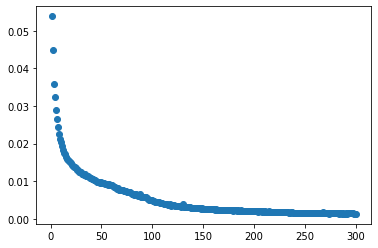

<Figure size 432x288 with 0 Axes>

In [60]:
epochs=np.arange(1,301)
plt.scatter(x=epochs,y=loss_history)
plt.show()
save_plot_to_file('Learning_Curve'+str(tm.time()))
save_model_to_file(iter1_model,'NN_model'+str(tm.time()))

#Using the trained model to find the maximum Yield

In [29]:
def generate_grid(n_scanning_parameters,n_points_each_dimension,high=1,low=0):
  points=np.linspace(high,low,num=n_points_each_dimension)
  x_points=[points for dimension in range(n_scanning_parameters)]
  mesh=np.array(np.meshgrid(*x_points))
  return mesh

def predict_grid(mesh,model):
  mesh=mesh.T
  points=np.array( [mesh[index].T for index in np.ndindex(*mesh.shape[1:])] )
  preds=model.predict(points)
  return points,preds

def find_max(mesh,model):
  points,preds=predict_grid(mesh,model)
  max_array_index=np.argmax(preds)
  max=preds[max_array_index]
  max_index=points[max_array_index]
  return max,max_index

In [61]:
grid=generate_grid(4,100,high=4)
print(grid.shape)
max,max_index=find_max(grid,iter1_model)
print(max,max_index)

(4, 100, 100, 100, 100)
[4.4401646] [3.55555556 4.         4.         3.35353535]


# Producing next protocol closer to minima